In [1]:
#general
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

#machine learning 
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.arima.model import ARIMA

#helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

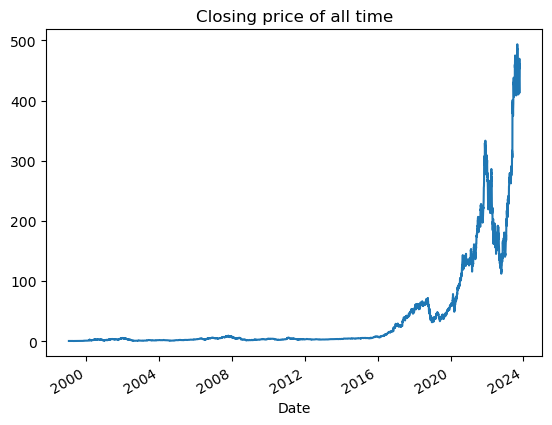

In [2]:
#getting a dataframe containing all pass NVDA stock prices 
nvda = yf.Ticker("NVDA")
nvda_df = nvda.history(period='max')
nvda_df['Close'].plot()
plt.title("Closing price of all time")
plt.show()
#upon plotting all historic data of NVDA, we see significanet change from
#2018 onwards, which is more relevant to the current context

In [3]:
#download NVDA stock data from 2017 to now
df = yf.download('NVDA', '2017-1-1', '2023-10-14')

[*********************100%%**********************]  1 of 1 completed


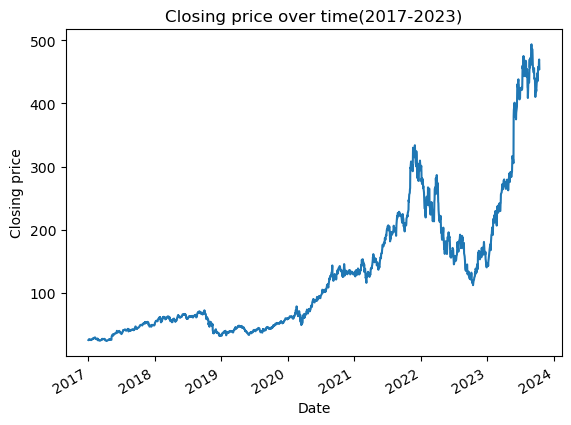

In [4]:
df['Close'].plot(use_index=True)
plt.ylabel("Closing price")
plt.title("Closing price over time(2017-2023)")
plt.show()


In [5]:
#preparation of data-----------------------------------------------------------------------------------------------

#to see how the closing price has changed from the day before
#1 indicating an increase while 0 indicates a decrease
df["Change"] = df["Close"] - df["Close"].shift(+1)
df["Change_yn"] = (df["Change"] > 0).astype(int)

#creating a function for simple moving average
def SMA(data, period, column):
    return data[column].rolling(window=period).mean()


df['SMA 5days'] = SMA(df, 5, 'Adj Close')
df['SMA 30days'] = SMA(df, 30, 'Adj Close')
df['SMA 50days'] = SMA(df, 50, 'Adj Close')
#remove the single nan value created from the shift
df = df.dropna()
df.isnull().sum().sum()


#standardising data 
Y = df['Change_yn']
X = df[['Open','High','Low','Close','Adj Close','Volume','SMA 5days','SMA 30days','SMA 50days']]
sc = StandardScaler()
X = sc.fit_transform(X)

#Standardised data to prevent outliers from influencing the model. Chosen to use StandardScalar as I take into account the volatility of the stock market and the possibility of extreme opening and closing values. 



In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [7]:
#From these 4 models, choose to focus on randomforest due to best accuracy score and lowest RMSE
models = [SVC,
          LogisticRegression,
          GaussianNB,
          RandomForestClassifier] 
           
accuracy = []
precision = []
recall = []
rmse = []
for m in models:
    model_ = m()
    model_.fit(X_train,Y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    prec = precision_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    mse = mean_squared_error(Y_test,pred)
    rmse.append(mse)
    accuracy.append(acc)
    precision.append(prec)
    recall.append(rec)
    print(f'RMSE of {m} is {rmse[-1]}')
    print(f'Accuracy of {m} is {accuracy[-1]}')
    print(f'Precision of {m} is {precision[-1]}')
    print(f'Recall score of {m} is {recall[-1]}')
    print("-------------------------------------")


RMSE of <class 'sklearn.svm._classes.SVC'> is 0.46686746987951805
Accuracy of <class 'sklearn.svm._classes.SVC'> is 0.5331325301204819
Precision of <class 'sklearn.svm._classes.SVC'> is 0.5288461538461539
Recall score of <class 'sklearn.svm._classes.SVC'> is 0.953757225433526
-------------------------------------
RMSE of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.3102409638554217
Accuracy of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.6897590361445783
Precision of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.6305970149253731
Recall score of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.976878612716763
-------------------------------------
RMSE of <class 'sklearn.naive_bayes.GaussianNB'> is 0.5030120481927711
Accuracy of <class 'sklearn.naive_bayes.GaussianNB'> is 0.49698795180722893
Precision of <class 'sklearn.naive_bayes.GaussianNB'> is 0.5115384615384615
Recall score of <class 'sklearn.naive_bayes.Gaus

In [8]:
#Conduct k-fold cross validation to ensure that scores of the model do not depend on the picked training and test set
kf = KFold(n_splits = 5)
models = [RandomForestClassifier, SVC]
for m in models:
    model_ = m()
    scores = cross_val_score(model_, X_train, Y_train, cv=kf)
    print(scores)

[0.69172932 0.59622642 0.61886792 0.66037736 0.65283019]
[0.57894737 0.5509434  0.50566038 0.50566038 0.53962264]


In [9]:
#checking the importance of each individual feature 
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)
predictors = ['Open','High','Low','Close','Adj Close','Volume','SMA 5days','SMA 30days','SMA 50days']
importancedf = pd.DataFrame({'features': predictors, 'importance':rf.feature_importances_})
importancedf

,features,importance
0,Open,0.138460
1,High,0.089787
2,Low,0.088557
3,Close,0.132225
4,Adj Close,0.131101
5,Volume,0.118921
6,SMA 5days,0.117192
7,SMA 30days,0.092205
8,SMA 50days,0.091552
